In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
df = pd.read_csv("../data/preprocessed.csv")

In [3]:
df.head()

,Unnamed: 0,Area,Country code,Year,Area type,Continent,Ember region,EU,OECD,G20,G7,ASEAN,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
0,66,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Clean,GW,0.19,0.0,0.0
1,67,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Fossil,GW,0.03,0.0,0.0
2,68,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Gas and Other Fossil,GW,0.03,0.0,0.0
3,69,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",GW,0.19,0.0,0.0
4,70,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Renewables,GW,0.19,0.0,0.0


In [4]:
recent_year = df['Year'].max()
categories = ['Electricity generation', 'Power sector emissions']
df_filtered = df[(df['Year'] == recent_year) & (df['Category'].isin(categories))]

In [5]:
# Pivot the data to have countries as rows and energy metrics as columns
df_pivot = df_filtered.pivot_table(values='Value', index='Area', 
                                   columns=['Category', 'Variable'], aggfunc='sum')

# Flatten column names
df_pivot.columns = [f"{cat}_{var}" for cat, var in df_pivot.columns]

# Drop any rows with missing values
df_pivot = df_pivot.dropna()

In [6]:
# Normalize the data
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_pivot), columns=df_pivot.columns, index=df_pivot.index)

In [9]:
# Perform K-means clustering
n_clusters = min(5, len(df_normalized))  # You can adjust this number based on your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_normalized['Cluster'] = kmeans.fit_predict(df_normalized)

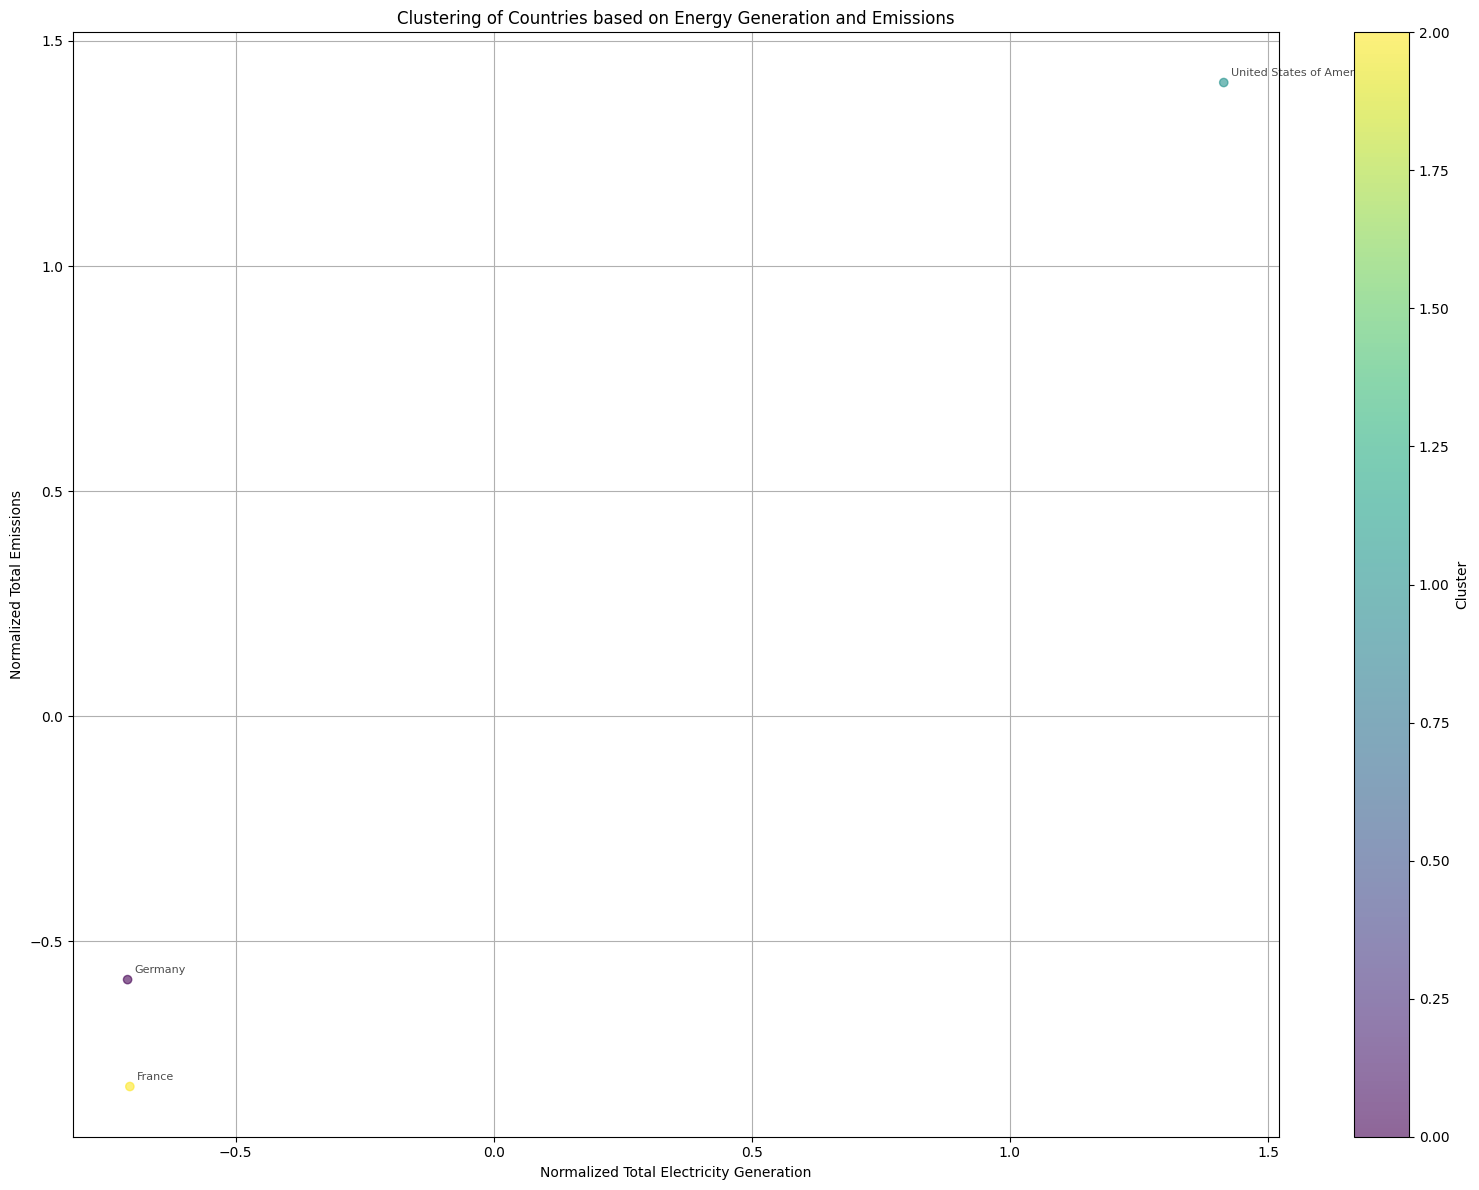


EU countries in each cluster:
Cluster 0: Germany
Cluster 1: 
Cluster 2: France

OECD countries in each cluster:
Cluster 0: Germany
Cluster 1: United States of America
Cluster 2: France

G20 countries in each cluster:
Cluster 0: Germany
Cluster 1: United States of America
Cluster 2: France

G7 countries in each cluster:
Cluster 0: Germany
Cluster 1: United States of America
Cluster 2: France

ASEAN countries in each cluster:
Cluster 0: 
Cluster 1: 
Cluster 2: 

Efficiency metrics for each cluster:
Cluster 0:
  Average Generation: -0.71
  Average Emissions: -0.59
  Efficiency (Generation/Emissions): 1.21
  Countries: Germany

Cluster 1:
  Average Generation: 1.41
  Average Emissions: 1.41
  Efficiency (Generation/Emissions): 1.00
  Countries: United States of America

Cluster 2:
  Average Generation: -0.70
  Average Emissions: -0.82
  Efficiency (Generation/Emissions): 0.86
  Countries: France

Analysis complete. Check 'country_clusters.png' for visualization and 'country_cluster_info.c

In [10]:
# Visualize the clusters based on Total Generation and Total Emissions
plt.figure(figsize=(16, 12))
scatter = plt.scatter(df_normalized['Electricity generation_Total Generation'], 
                      df_normalized['Power sector emissions_Total emissions'], 
                      c=df_normalized['Cluster'], cmap='viridis', alpha=0.6)

# Annotate points with country names
for idx, row in df_normalized.iterrows():
    plt.annotate(idx, (row['Electricity generation_Total Generation'], 
                       row['Power sector emissions_Total emissions']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.xlabel('Normalized Total Electricity Generation')
plt.ylabel('Normalized Total Emissions')
plt.title('Clustering of Countries based on Energy Generation and Emissions')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('country_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze clusters by association
associations = ['EU', 'OECD', 'G20', 'G7', 'ASEAN']

# Create a dictionary to store association information for each country
df_associations = df[df['Area'].isin(df_normalized.index)].groupby('Area')[associations].first()

for assoc in associations:
    print(f"\n{assoc} countries in each cluster:")
    for cluster in range(n_clusters):
        countries = df_normalized[
            (df_normalized['Cluster'] == cluster) & 
            (df_associations[assoc] == 1)
        ].index.tolist()
        print(f"Cluster {cluster}: {', '.join(countries)}")

# Calculate and print efficiency metrics for each cluster
print("\nEfficiency metrics for each cluster:")
for cluster in range(n_clusters):
    cluster_data = df_normalized[df_normalized['Cluster'] == cluster]
    avg_generation = cluster_data['Electricity generation_Total Generation'].mean()
    avg_emissions = cluster_data['Power sector emissions_Total emissions'].mean()
    efficiency = avg_generation / avg_emissions if avg_emissions != 0 else float('inf')
    print(f"Cluster {cluster}:")
    print(f"  Average Generation: {avg_generation:.2f}")
    print(f"  Average Emissions: {avg_emissions:.2f}")
    print(f"  Efficiency (Generation/Emissions): {efficiency:.2f}")
    print(f"  Countries: {', '.join(cluster_data.index.tolist())}")
    print()

# Save cluster information to a CSV file
cluster_info = df_normalized[['Cluster']].join(df_pivot)
cluster_info.to_csv('country_cluster_info.csv')

print("Analysis complete. Check 'country_clusters.png' for visualization and 'country_cluster_info.csv' for detailed cluster information.")